# Corrected overfitting issue

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

C:\Users\Mahtab\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data = pd.read_excel("Extruder_model.xlsx")
data

,mass_flow(kg/h),screw_speed(rpm),solid_content(%),Energy(kJ/kg),Torque(N.m)
0,2.28,800,70.0,6552.149619,2.972000
1,2.28,1000,70.0,9031.174828,3.277172
2,2.28,1200,70.0,8612.666192,2.604422
3,4.56,800,70.0,3868.788613,3.509700
4,4.56,1000,70.0,4463.403908,3.239300
...,...,...,...,...,...
63,6.84,1000,85.0,8257.584290,8.989370
64,6.84,1200,85.0,10161.012782,9.217900
65,9.13,1200,85.0,8098.660981,9.806700
66,11.41,1200,85.0,6704.428438,10.145800


In [101]:
data = pd.read_excel("Extruder_model.xlsx")
data = data.sample(frac=1)
X_data = data.drop(["Energy(kJ/kg)" , "Torque(N.m)"],axis=1)
Y_data = data["Energy(kJ/kg)"].values
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

In [102]:
# difine the function
def grid_search(max_depths:list,n_estimators :list,cv:int =5):
    df = pd.DataFrame()
    for n_estimator in n_estimators:
    
        for md in max_depths:
            
            model_GradientBoostingRegressor= GradientBoostingRegressor( learning_rate=0.2, max_depth=md, n_estimators=n_estimator)
            cv_results = cross_validate(model_GradientBoostingRegressor,X_data,Y_data.reshape(-1,),cv=cv,scoring=('neg_mean_absolute_error'),return_train_score=True)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["train_score"][i]] , "type" : "train"})],axis =0)
            for i in range(cv):
                df = pd.concat( [df,pd.DataFrame(data={"max_depth":md,"n_estimators" :n_estimator , "cv_result" :[-1*cv_results["test_score"][i]] , "type" : "test"})],axis =0)

    
    return df

In [103]:
# call the function
cv_gs_results = grid_search([1,2,3],[10,50,100,150,200,300],cv=10)
cv_gs_results.sort_values(["n_estimators","max_depth"],inplace=True)
cv_gs_results["md_nes"] = cv_gs_results.apply(lambda x:(x.max_depth , x.n_estimators),axis=1)

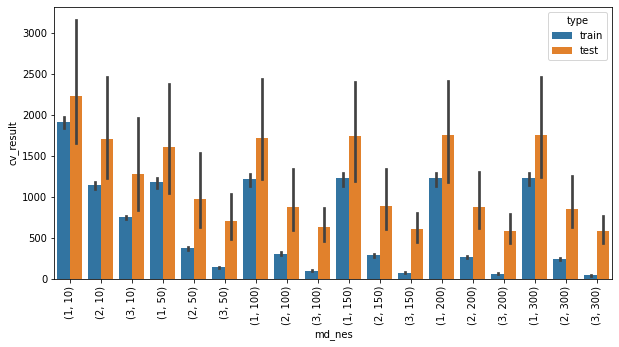

In [104]:
ax, fig  = plt.subplots(1,1,figsize = (10,5))
ax = sns.barplot(data=cv_gs_results , x =cv_gs_results["md_nes"] , y = "cv_result" ,hue = "type" )
ax.set_xticklabels(ax.get_xticklabels() ,rotation = 90);

In [105]:
df_plt = cv_gs_results.groupby(["md_nes", "type"],as_index=False).mean().drop(["max_depth" , "n_estimators"],axis=1)

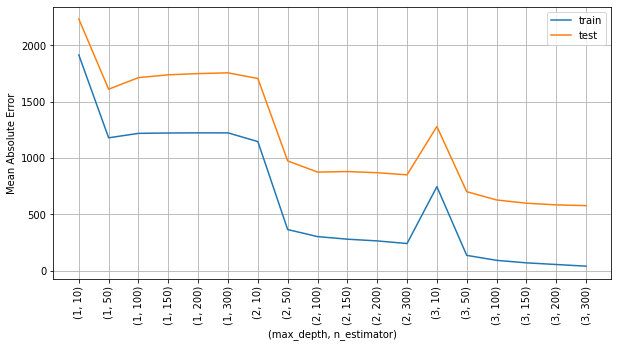

In [106]:
plt.figure(figsize=(10,5) )
plt.plot(list(map(str,df_plt[df_plt["type"] == "train"].md_nes.values)),  list(df_plt[df_plt["type"] == "train"].cv_result.values),label = "train")
plt.plot(list(map(str,df_plt[df_plt["type"] == "test"].md_nes.values)),  list(df_plt[df_plt["type"] == "test"].cv_result.values),label = "test")
plt.xticks(rotation = 90)
plt.xlabel("(max_depth, n_estimator)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(which = "both")

In [107]:
model_Energy= GradientBoostingRegressor( learning_rate=0.2, max_depth=3, n_estimators=150)
Energy = cross_validate(model_Energy,X_data,Y_data.reshape(-1,),cv=10,scoring=('neg_mean_absolute_error'),return_train_score=True)

In [108]:
print("test scores:\n",list(map(abs,Energy["test_score"])))
print("mean:  ",abs(np.mean(Energy["test_score"])) )
print("\n\n")
print("train scores:\n",list(map(abs,Energy["train_score"])))
print("mean:  ",abs(np.mean(Energy["train_score"]) ))


test scores:
 [561.7246514270421, 337.38452855996087, 537.6689397739848, 513.9103868968332, 478.7980067848956, 657.5249722468777, 314.4817663284216, 746.2441061666926, 404.0859831260123, 1437.8998986861668]
mean:   598.9723239996888



train scores:
 [87.04650759332212, 72.45203165617737, 70.92056973502615, 67.9186106020625, 66.35025837193692, 54.50219848454287, 82.87488999279054, 71.86980827967646, 72.07027445301624, 69.40517254590351]
mean:   71.54103217144548


In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)
model_Energy= GradientBoostingRegressor( learning_rate=0.2, max_depth=3, n_estimators=150)
model_Energy.fit(X_train,y_train)
y_pred=model_Energy.predict(X_test)

In [110]:
from joblib import dump, load
dump(model_Energy,'model_Energy.h5') 

['model_Energy.h5']

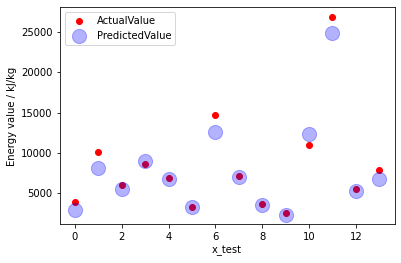

In [97]:
#plots
plt.scatter(list(range(len(y_pred))),y_test, c= ('red'))
plt.scatter(list(range(len(y_pred))),y_pred, c= ('blue'),alpha=0.3,s=200)
plt.xlabel('x_test')
plt.ylabel('Energy value / kJ/kg')
plt.legend(['ActualValue', 'PredictedValue'])
plt.show()

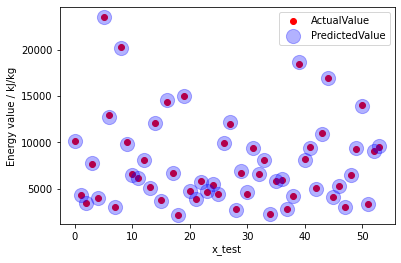

In [98]:
#plots
plt.scatter(list(range(len(y_train))),y_train, c= ('red'))
plt.scatter(list(range(len(y_train))),model_Energy.predict(X_train), c= ('blue'),alpha=0.3,s=200)
plt.xlabel('x_test')
plt.ylabel('Energy value / kJ/kg')
plt.legend(['ActualValue', 'PredictedValue'])
plt.show()